In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_new = pd.read_csv('selected_features_weatherdata.csv',parse_dates=['last_updated'], index_col='last_updated')

In [3]:
df_new.head()

,temperature_celsius,pressure_in,humidity,uv_index,wind_kph,cloud
last_updated,,,,,,
2024-05-16 13:15:00,26.6,29.89,24,7.0,13.3,30
2024-05-16 10:45:00,19.0,29.88,94,5.0,11.2,75
2024-05-16 09:45:00,23.0,29.85,29,5.0,15.1,0
2024-05-16 10:45:00,6.3,29.75,61,2.0,11.9,100
2024-05-16 09:45:00,26.0,29.85,89,8.0,13.0,50


In [4]:
df_new.shape

(70747, 6)

In [5]:
def create_lag_features(df, target_col, lags=[1, 2, 3]):
    for lag in lags:
        df[f'{target_col}_t-{lag}'] = df[target_col].shift(lag)
    return df


In [6]:
df_new = create_lag_features(df_new, 'temperature_celsius', lags=[1, 2, 3])
df_new.dropna(inplace=True)

In [7]:
df_new.head()

,temperature_celsius,pressure_in,humidity,uv_index,wind_kph,cloud,temperature_celsius_t-1,temperature_celsius_t-2,temperature_celsius_t-3
last_updated,,,,,,,,,
2024-05-16 10:45:00,6.3,29.75,61,2.0,11.9,100,23.0,19.0,26.6
2024-05-16 09:45:00,26.0,29.85,89,8.0,13.0,50,6.3,23.0,19.0
2024-05-16 04:45:00,26.0,29.91,84,1.0,9.0,25,26.0,6.3,23.0
2024-05-16 05:45:00,8.0,29.94,93,1.0,3.6,0,26.0,26.0,6.3
2024-05-16 12:45:00,19.0,30.03,40,4.0,6.8,25,8.0,26.0,26.0


In [8]:
train_size = int(0.8 * len(df_new))
train_df = df_new.iloc[:train_size]
test_df = df_new.iloc[train_size:]


In [9]:
features = [col for col in train_df.columns if 't-' in col]
X_train = train_df[features]
y_train = train_df['temperature_celsius']

In [11]:
from xgboost import XGBRegressor
model = XGBRegressor(objective='reg:squarederror', random_state=42)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=None,
             n_jobs=None, num_parallel_tree=None, ...)

In [12]:
def multi_step_forecast(model, last_known_values, n_steps):
    forecast = []
    input_data = last_known_values.copy()

    for _ in range(n_steps):
        pred = model.predict(input_data.values.reshape(1, -1))[0]
        forecast.append(pred)
        
        # Update lags for next step
        input_data = input_data.shift(1)
        input_data.iloc[0] = pred  # Replace lag-1 with current prediction

    return forecast


In [13]:
last_row = test_df.iloc[-1]
last_known = last_row[features]

forecast_7_days = multi_step_forecast(model, last_known, n_steps=7)


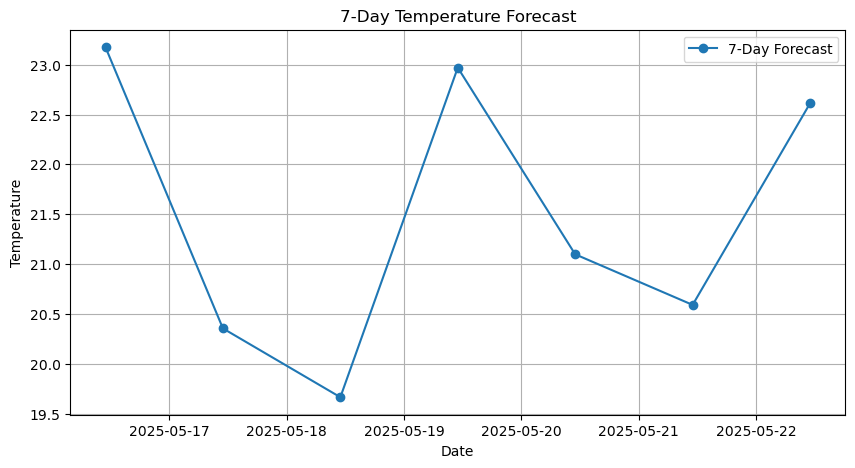

In [14]:
import matplotlib.pyplot as plt
import pandas as pd

future_dates = pd.date_range(start=test_df.index[-1], periods=8, freq='D')[1:]

plt.figure(figsize=(10, 5))
plt.plot(future_dates, forecast_7_days, marker='o', label='7-Day Forecast')
plt.title('7-Day Temperature Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.grid(True)
plt.legend()
plt.show()


In [32]:
import joblib
# Save the trained model
joblib.dump(model, 'xgb_7day_forecast.pkl')

['xgb_7day_forecast.pkl']